# Analysis of inflection points

Determines the relationship between treatment time $\mathrm{T_H}$ and the two inflection point times, $\mathrm{T1}$ and $\mathrm{T2}$, and also the relationship between the two inflection points.

In [1]:
import sys,os
import numpy as np
import pandas as pd
import scipy.optimize as optim
import functions
import glob
from scipy.stats import gamma
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as st
import matplotlib.font_manager as font_manager
from scipy.stats import t

from matplotlib.lines import Line2D

In [2]:
def linear(x,a,b):
    return (a + b*x)

In [3]:
data_directory = './data/'
os.chdir(data_directory)
cwd = os.getcwd()

studies = glob.glob('Study*')

n = [int(s.lstrip('Study')) for s in studies]
n.sort()

print(n)

studies = ['Study'+str(ni) for ni in n]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Specify inflection points to neglect from specific studies.

In [4]:
studies_to_neglect = {}

studies_to_neglect = {'Study1':[60],'Study2':[60],'Study3':[60],'Study4':[30],
                     'Study5':[30],'Study6':[60],'Study7':[60],'Study8':[],
                     'Study9':[],'Study10':[],'Study11':[],'Study12':[60]}

In [5]:
inflection_points = {}
dof = -2 # Two parameters in the linear models

for s in studies:
    os.chdir(s)
    
    inflection_points[s] = pd.read_csv('gompertz_inflection_points_summary.csv')
    
    for tH in studies_to_neglect[s]:
        tH_vals = inflection_points[s].index[inflection_points[s]['CT'] == tH].tolist()[0]
        
        inflection_points[s] = inflection_points[s].drop(inflection_points[s].index[tH_vals])
        
    dof += len(inflection_points[s]['CT'])
    
    os.chdir(cwd)
    
print('Degrees of freedom: ',dof)

Degrees of freedom:  73


In [6]:
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)
print(ts)

1.9929971255321668


**Relationship between $\mathrm{T_H}$ and $\mathrm{T1}$.**

In [7]:
th, t1s = [], []

for s in studies:
    th += inflection_points[s]['CT'].to_list()
    t1s += inflection_points[s]['T1'].to_list()

results = optim.curve_fit(linear,th,t1s,full_output=True)

popt, pcov = results[0], results[1]

x = np.linspace(0,80,100)
t1 = linear(x,popt[0],popt[1])

residual = linear(np.array(th),popt[0],popt[1]) - np.array(t1s)

norm_RSS = math.sqrt(np.dot(residual,residual)/(len(t1s)-2))

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

res = st.linregress(th,t1s)

23.23241902551115


In [8]:
fitname = r'T1 = ' + str(round(res.slope,2)) + '$\mathrm{T_H}$ + ' + str(round(res.intercept,2))

x = np.linspace(0,80,100)
y = res.slope*x + res.intercept

r_text = r'$\mathrm{R}^2 = ' + str(round(res.rvalue**2,3)) + '$'

In [10]:
n_samples = 10000

s_is, i_is = [], []

t1_up = np.zeros(shape=x.shape)
t1_low = np.zeros(shape=x.shape)

rt1_up = np.zeros(shape=x.shape)
rt1_low = np.zeros(shape=x.shape)

effective_sigma = np.zeros(shape=x.shape)

for i in range(0,x.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(x[i],a_sample,b_sample))
        
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    t1_low[i], t1_up[i] = t1[i] - ci95, t1[i] + ci95
    
    rt1_low[i], rt1_up[i] = t1[i] - sigma*ts, t1[i] + sigma*ts

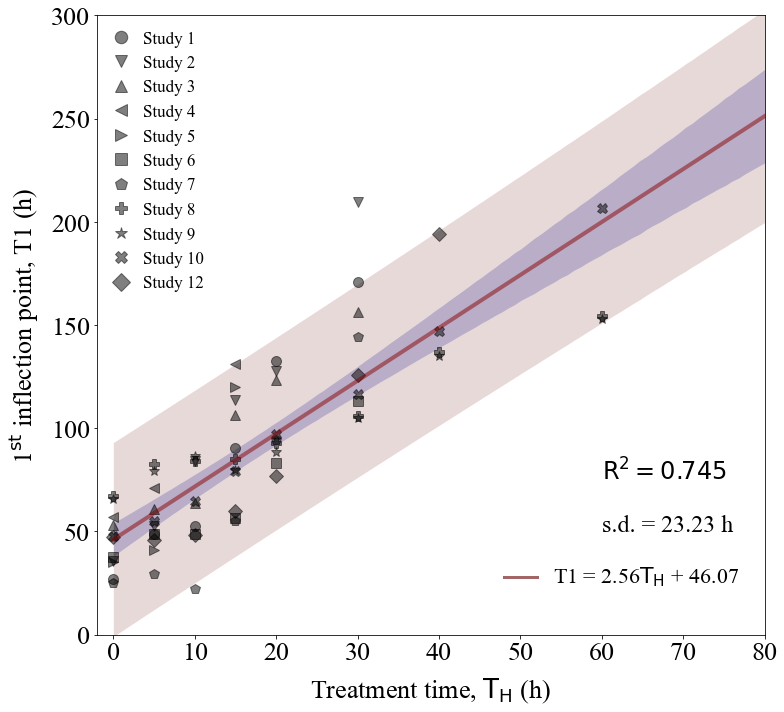

In [11]:
all_markers = ["o","v","^","<",">","s","p","P","*","X","d","D"]

fig, axs = plt.subplots(figsize=(11,10))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

#marker_list = {'Study1':'o','Study2':'D','Study3':'s','Study4':'X','Study5':'P'}

for s,mark in zip(studies,all_markers):
    if '11' not in s:
        labelname = s.replace('Study','Study ')
        plt.plot(inflection_points[s]['CT'],inflection_points[s]['T1'],marker=mark,ms=10,color='black',alpha=0.5,linewidth=0,label=labelname)

plt.plot(x,y,linewidth=4,color='#880000',alpha=0.5)

plt.text(60,75,r_text,fontsize=24)
plt.text(60,50,RSS_text,fontsize=24)

plt.fill_between(x,t1_up,t1_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(x,rt1_up,rt1_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.text(54,25,fitname,fontsize=22)
plt.plot(np.linspace(48,52,2),28*np.ones(2,),color='#660000',alpha=0.6,lw=3)
    
plt.xticks(size=26)
plt.yticks(size=26)  
plt.xlabel(r'Treatment time, $\mathrm{T_H}$ (h)',size=26,labelpad=10)
plt.ylabel(r'1$^{\mathrm{st}}$ inflection point, T1 (h)',size=26,rotation=90,labelpad=10)
plt.xlim(-2,80)
plt.ylim(0,300)
plt.legend(frameon=False,prop={'size': 17,'family':'Times New Roman'},markerscale=1.25,handlelength=1.0,loc='upper left')
plt.tight_layout()

#plt.savefig('THT1.png',dpi=300)

**Relationship between $\mathrm{T_H}$ and $\mathrm{T2}$.**

In [12]:
th, t2s = [], []

for s in studies:
    th += inflection_points[s]['CT'].to_list()
    t2s += inflection_points[s]['T2'].to_list()

results = optim.curve_fit(linear,th,t2s,full_output=True)

popt, pcov = results[0], results[1]

x = np.linspace(0,80,100)
t2 = linear(x,popt[0],popt[1])

residual = linear(np.array(th),popt[0],popt[1]) - np.array(t2s)

norm_RSS = math.sqrt(np.dot(residual,residual)/(len(t2s)-2))

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

In [13]:
fitname = r'$\mathrm{T2}$ = ' + str(round(res.slope,2)) + '$\mathrm{T_H}$ + ' + str(round(res.intercept,2)) 

r_text = r'$\mathrm{R}^2 = ' + str(round(res.rvalue**2,3)) + '$'

In [14]:
n_samples = 10000

s_is, i_is = [], []

t2_up = np.zeros(shape=x.shape)
t2_low = np.zeros(shape=x.shape)

rt2_up = np.zeros(shape=x.shape)
rt2_low = np.zeros(shape=x.shape)

effective_sigma = np.zeros(shape=x.shape)

wf = open('t2-cis-th.csv','w')

for i in range(0,x.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(x[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    #t2_low[i], t2_up[i] = ci[0], ci[1]
    
    t2_low[i], t2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = t2[i] - sigma*ts, t2[i] + sigma*ts
    
    print(str(t2[i])+','+str((rt2_up[i]-rt2_low[i])/t2[i])+','+str((t2_up[i]-t2_low[i])/t2[i]),file=wf)

wf.close()

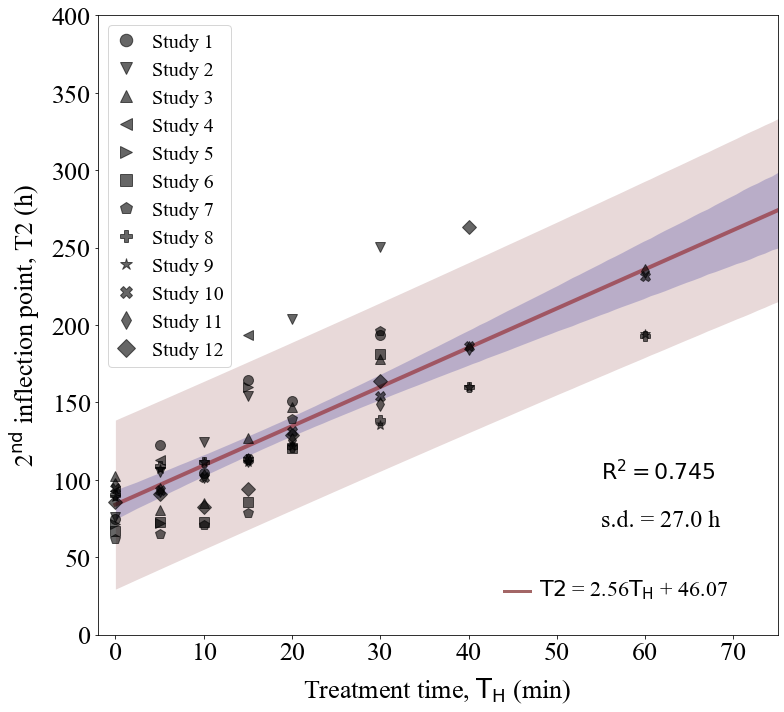

In [19]:
fig, axs = plt.subplots(figsize=(11,10))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(x,t2,linewidth=4,color='#880000',alpha=0.5)#,label=fitname)

for s,mark in zip(studies,all_markers):
    labelname = s.replace('Study','Study ')
    plt.plot(inflection_points[s]['CT'],inflection_points[s]['T2'],marker=mark,ms=10,color='black',alpha=0.6,linewidth=0,label=labelname)

plt.text(55,100,r_text,fontsize=22)
plt.text(55,70,RSS_text,fontsize=24)

plt.text(48,25,fitname,fontsize=22)

plt.plot(np.linspace(44,47,2),28*np.ones(2,),color='#660000',alpha=0.6,lw=3)

plt.fill_between(x,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(x,rt2_up,rt2_low,alpha=0.2,color='#000088',linewidth=0.0)
    
plt.xticks(size=26)
plt.yticks(size=26)  
plt.xlabel(r'Treatment time, $\mathrm{T_H}$ (min)',size=26,labelpad=10)
plt.ylabel(r'2$^{\mathrm{nd}}$ inflection point, T2 (h)',size=26,rotation=90,labelpad=10)
plt.xlim(-2,75)
plt.ylim(0,400)
plt.legend(frameon=True,prop={'size': 20,'family':'Times New Roman'},markerscale=1.25,handlelength=1.0,loc='upper left')
plt.tight_layout()

#plt.savefig('THT2-new2.png',dpi=300)

**Relationship between $\mathrm{T1}$ and $\mathrm{T2}$.**

In [20]:
res = functions.fit_data(inflection_points,'T1','T2')

s_err = ts*res.stderr
i_err = ts*res.intercept_stderr

In [21]:
fitname = r'$\mathrm{T2}$ = ' + str(round(res.slope,2)) + '$\mathrm{T1}$ + ' + str(round(res.intercept,2)) 

x = np.linspace(0,400,100)
y = res.slope*x + res.intercept

r_text = r'$\mathrm{R}^2 = ' + str(round(res.rvalue**2,3)) + '$'

reduced_chi = functions.reduced_chi_square(inflection_points,'T1','T2',res.slope,res.intercept)

reduced_chi_text = r'Reduced chi-square error = ()'+str(round(reduced_chi,2))+' h)$^2$'

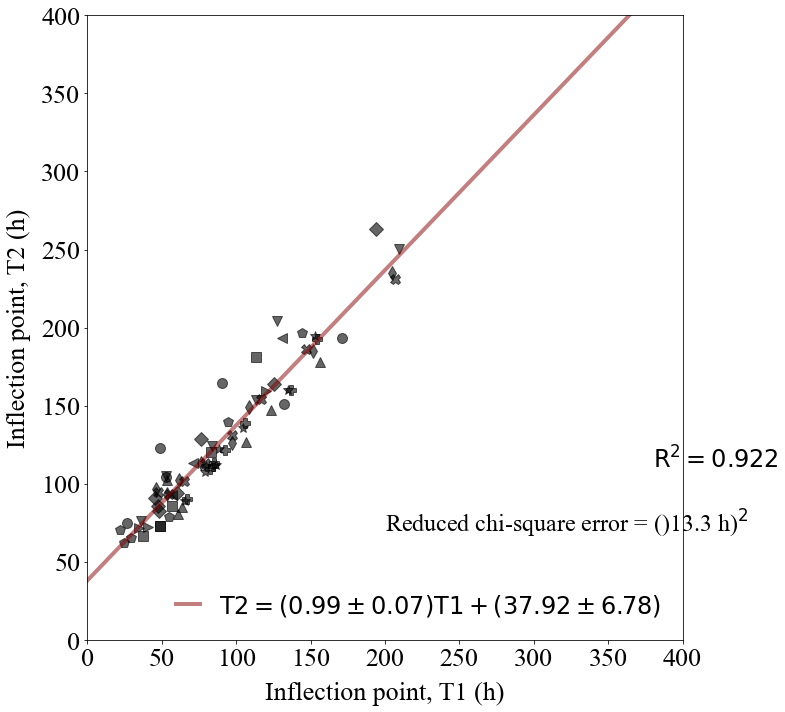

In [23]:
fig, axs = plt.subplots(figsize=(11,10))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

for s,mark in zip(studies,all_markers):
    labelname = s.replace('Study','Study ')
    plt.plot(inflection_points[s]['T1'],inflection_points[s]['T2'],marker=mark,ms=10,color='black',alpha=0.6,linewidth=0)

plt.plot(x,y,linewidth=4,color='#880000',alpha=0.5,label=fitname)
plt.text(380,110,r_text,fontsize=24)
plt.text(200,70,reduced_chi_text,fontsize=24)
    
plt.xticks(size=26)
plt.yticks(size=26)  
plt.xlabel('Inflection point, T1 (h)',size=26,labelpad=10)
plt.ylabel('Inflection point, T2 (h)',size=26,rotation=90,labelpad=10)
plt.xlim(0,400)
plt.ylim(0,400)
plt.legend(frameon=False,prop={'size': 24,'family':'Times New Roman'},markerscale=1.25,handlelength=1.0,loc='lower right')
plt.tight_layout()
plt.savefig('T1T2.png',dpi=300)